In [275]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import contextily as ctx
import h3
import statsmodels as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tools.tools import add_constant
import matplotlib.ticker as ticker
import jenkspy

In [353]:
zip = pd.read_csv(r'C:\Users\wetzl\Desktop\Python\EOI\zhvi.csv')
CAzhvi = zip[zip['State'] == 'CA']
CAzhvi.head
num_CA_observations = len(CAzhvi)

print(f'Total number of observations for California: {num_CA_observations}')
#CAzhvi.to_csv(r'C:\Users\wetzl\Desktop\Python\EOI\CAzhvi.csv')
zipshp = gpd.read_file(r'C:\Users\wetzl\Desktop\ArcGIS\data\borders\zipcodes2020\California_Zip_Codes.shp')
zipshp.head

Total number of observations for California: 1544


C:\Users\wetzl\PycharmProjects\earth-engine\venv\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\Users\wetzl\Desktop\ArcGIS\data\borders\zipcodes2020\California_Zip_Codes.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<bound method NDFrame.head of      ZIP_CODE                  PO_NAME STATE  POPULATION   POP_SQMI  \
0       00012          Mt Meadows Area    CA         -99 -99.000000   
1       00016  Sequoia National Forest    CA         -99 -99.000000   
2       00017  Northeast Fresno County    CA         -99 -99.000000   
3       00018    Los Padres Ntl Forest    CA         -99 -99.000000   
4       00019        Lassen Ntl Forest    CA         -99 -99.000000   
...       ...                      ...   ...         ...        ...   
1716    96146           Olympic Valley    CA        1152 149.420000   
1717    96148              Tahoe Vista    CA        1487 991.330000   
1718    96150         South Lake Tahoe    CA       32999 151.870000   
1719    96161                  Truckee    CA       19416  99.570000   
1720    96162                  Truckee    CA         352 838.100000   

           SQMI                                           geometry  
0     30.920000  POLYGON ((-235397.856 9938636.4

CAzhvi.loc[:, 'RegionName'] = CAzhvi['RegionName'].astype(str).str.zfill(5)
zipshp.loc[:, 'ZIP_CODE'] = zipshp['ZIP_CODE'].astype(str).str.zfill(5)

date_columns = [col for col in CAzhvi.columns if col.count('/') == 2]  # Identify date columns by format
filtered_date_columns = [col for col in date_columns if int(col.split('/')[-1]) <= 2019]

necessary_columns = ['RegionID', 'RegionName', 'City', 'Metro', 'CountyName'] + filtered_date_columns
CAzhvi_filtered = CAzhvi[necessary_columns]
print(CAzhvi_filtered.head())
print(CAzhvi_filtered.shape[0])

CAzhvi_filtered.rename(columns={'RegionName': 'ZIP_CODE'}, inplace=True)
merged_gdf = zipshp.merge(CAzhvi_filtered, on='ZIP_CODE')

merged_gdf = merged_gdf.drop(columns=['geometry_y'])

merged_gdf.set_geometry('geometry_x', inplace=True)
merged_gdf = merged_gdf.rename_geometry('geometry')

output_shapefile_path = r'C:\Users\wetzl\Desktop\Python\EOI\CAzhvizip\CAzhvi4.shp'
#merged_gdf.to_file(output_shapefile_path)

merged_gdf = merged_gdf.columns[10:]
merged_gdf.columns = pd.to_datetime(merged_gdf).columns
zhvi_yearly = merged_gdf.groupby(merged_gdf.columns.year, axis=1).mean()
print(zhvi_yearly.head())

In [334]:
# Standardizing ZIP codes
CAzhvi['RegionName'] = CAzhvi['RegionName'].astype(str).str.zfill(5)
zipshp['ZIP_CODE'] = zipshp['ZIP_CODE'].astype(str).str.zfill(5)

# Identifying and filtering date columns
date_columns = [col for col in CAzhvi.columns if col.count('/') == 2]  # Identify date columns by format
filtered_date_columns = [col for col in date_columns if int(col.split('/')[-1]) <= 2019]

# Selecting necessary columns
necessary_columns = ['RegionID', 'RegionName', 'City', 'Metro', 'CountyName'] + filtered_date_columns
CAzhvi_filtered = CAzhvi[necessary_columns]
CAzhvi_filtered = CAzhvi_filtered.rename(columns={'RegionName': 'ZIP_CODE'})

# Set non-date columns
non_date_columns = ['RegionID', 'ZIP_CODE', 'City', 'Metro', 'CountyName']

# Set the non-date columns as the index
CAzhvi_filtered.set_index(non_date_columns, inplace=True)

# Convert the date columns to datetime to extract years
CAzhvi_filtered.columns = pd.to_datetime(CAzhvi_filtered.columns, format='%d/%m/%Y')

# Group by year and calculate the mean for each year
CAzhvi_yearly = CAzhvi_filtered.T.groupby(CAzhvi_filtered.columns.year).mean().T

# Reset index to bring non-date columns back as columns
CAzhvi_yearly.reset_index(inplace=True)

# Rename columns to a more readable format
CAzhvi_yearly.columns.name = None
CAzhvi_yearly.columns = non_date_columns + [f'{year}' for year in CAzhvi_yearly.columns[len(non_date_columns):]]

# Calculate the average of all yearly columns and add it as a new column
CAzhvi_yearly['Average'] = CAzhvi_yearly.iloc[:, len(non_date_columns):].mean(axis=1)

# Ensure the original geometry column is named 'geometry'
if 'geometry' not in zipshp.columns:
    zipshp = zipshp.rename_geometry('geometry')

# Perform a full outer join to include all geometries
merged_gdf = zipshp.merge(CAzhvi_yearly, on='ZIP_CODE', how='outer')

# Ensure 'geometry' column is set correctly
merged_gdf = merged_gdf.set_geometry('geometry')

# Print the new GeoDataFrame with yearly averages and final average column
print(merged_gdf.head())

C:\Users\wetzl\AppData\Local\Temp\ipykernel_22020\3307138659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAzhvi['RegionName'] = CAzhvi['RegionName'].astype(str).str.zfill(5)


  ZIP_CODE                  PO_NAME STATE  POPULATION   POP_SQMI       SQMI  \
0    00012          Mt Meadows Area    CA  -99.000000 -99.000000  30.920000   
1    00016  Sequoia National Forest    CA  -99.000000 -99.000000  39.330000   
2    00017  Northeast Fresno County    CA  -99.000000 -99.000000 564.380000   
3    00018    Los Padres Ntl Forest    CA  -99.000000 -99.000000  90.830000   
4    00019        Lassen Ntl Forest    CA  -99.000000 -99.000000 412.590000   

                                            geometry  RegionID City Metro  \
0  POLYGON ((-235397.856 9938636.426, -235571.593...       NaN  NaN   NaN   
1  POLYGON ((463415.33 8230735.164, 450342.706 82...       NaN  NaN   NaN   
2  POLYGON ((354976.178 8923823.768, 354863.088 8...       NaN  NaN   NaN   
3  POLYGON ((355769.015 7866496.399, 348656.291 7...       NaN  NaN   NaN   
4  POLYGON ((384.567 10127749.312, 294.796 101278...       NaN  NaN   NaN   

   ... 2011  2012  2013  2014  2015  2016  2017  2018  2019  A

     ZIP_CODE PO_NAME STATE  POPULATION  POP_SQMI  SQMI geometry     RegionID  \
1750    95930     NaN   NaN         NaN       NaN   NaN     None 98484.000000   
1751    95978     NaN   NaN         NaN       NaN   NaN     None 98528.000000   
1752    96009     NaN   NaN         NaN       NaN   NaN     None 98547.000000   
1753    96037     NaN   NaN         NaN       NaN   NaN     None 98570.000000   
1754    96084     NaN   NaN         NaN       NaN   NaN     None 98606.000000   

                City           Metro  ...          2011          2012  \
1750   Clipper Mills       Chico, CA  ... 131429.314176 116084.406315   
1751             NaN       Chico, CA  ...  50822.272296  49511.639296   
1752          Bieber  Susanville, CA  ...  95679.335211  99678.652689   
1753            Etna             NaN  ...           NaN           NaN   
1754  Round Mountain     Redding, CA  ...           NaN           NaN   

              2013          2014          2015          2016          2017

C:\Users\wetzl\AppData\Local\Temp\ipykernel_22020\2485192652.py:29: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


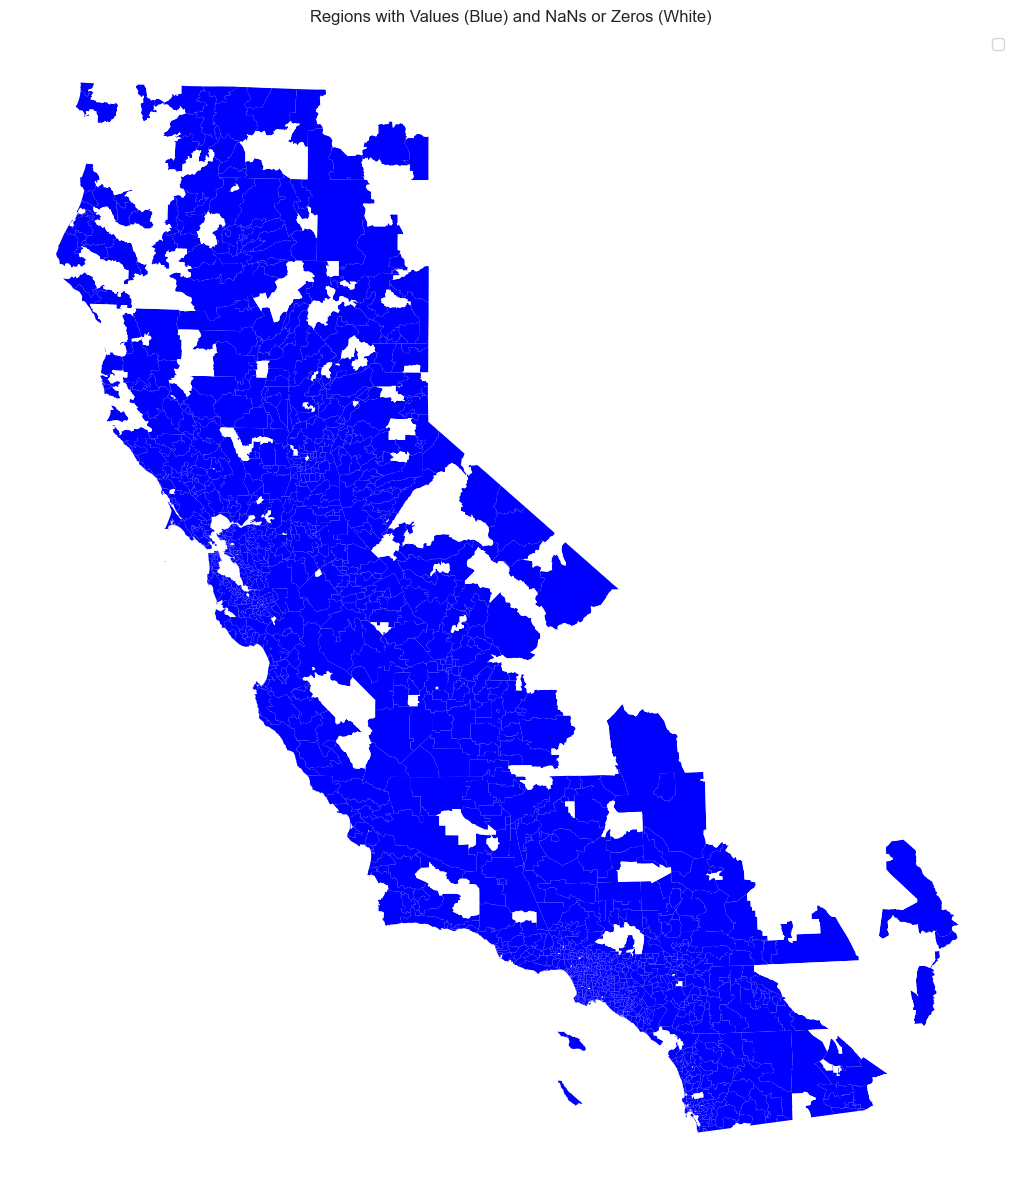

In [335]:
print(merged_gdf.tail())
print(merged_gdf.shape[1])
print(merged_gdf.shape[0])

num_nans = merged_gdf['Average'].isna().sum()

# Count the number of zeros in the 'Average' column
num_zeros = (merged_gdf['Average'] == 0).sum()

# Count the number of missing values (NaNs) in the 'Average' column
# This is the same as the count of NaNs
num_missing = num_nans

# Print the results
# Create a new column to indicate regions with values and regions with NaNs or zeros
merged_gdf['value_indicator'] = merged_gdf['Average'].apply(lambda x: 'Value' if pd.notna(x) and x != 0 else 'No Value')

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot regions with values
merged_gdf[merged_gdf['value_indicator'] == 'Value'].plot(ax=ax, color='blue', edgecolor='none',  label='Value')

# Plot regions with NaNs or zeros
merged_gdf[merged_gdf['value_indicator'] == 'No Value'].plot(ax=ax, color='white', edgecolor='none',  label='No Value')

# Add a title and legend
plt.title('Regions with Values (Blue) and NaNs or Zeros (White)')
plt.legend()
plt.axis('off')
plt.show()

output_shapefile_path = r'C:\Users\wetzl\Desktop\Python\EOI\CAzhvizip\CAzhvi6.shp'
#merged_gdf.to_file(output_shapefile_path)

# Define a function to convert a Point geometry to an H3 hexagon index
def point_to_h3(lat, lon, resolution):
    return h3.geo_to_h3(lat, lon, resolution)

# Apply the function to convert the centroid of the geometry column to H3 hexagons at resolution 7
merged_gdf['h3_index'] = merged_gdf.geometry.centroid.apply(lambda geom: point_to_h3(geom.y, geom.x, 7))

# Define a function to convert H3 hexagon index to centroid points
def h3_to_point(h3_index):
    lat, lon = h3.h3_to_geo(h3_index)
    return Point(lon, lat)

# Create a DataFrame with the H3 indices and their corresponding centroid points
h3_df = pd.DataFrame(merged_gdf['h3_index'].unique(), columns=['h3_index'])
h3_df['geometry'] = h3_df['h3_index'].apply(h3_to_point)
h3_gdf = gpd.GeoDataFrame(h3_df, geometry='geometry', crs=merged_gdf.crs)  # Ensure the CRS matches

# Reproject h3_gdf to match the CRS of merged_gdf if they don't match
if h3_gdf.crs != merged_gdf.crs:
    h3_gdf = h3_gdf.to_crs(merged_gdf.crs)

# Spatial join to match H3 center points with the original polygons
joined_gdf = gpd.sjoin(h3_gdf, merged_gdf, how='left', predicate='within')

# Print columns of the joined_gdf to debug
print(joined_gdf.columns)

# Check if 'h3_index' is in the columns of joined_gdf
if 'h3_index_left' not in joined_gdf.columns:
    joined_gdf['h3_index_left'] = joined_gdf.index

# Ensure 'geometry' column in joined_gdf is the centroid points
# We need to inspect the actual columns available in joined_gdf
# We will update our column selection based on the inspection output

# Adjust the column selection based on the actual columns present
if 'h3_index_left' in joined_gdf.columns:
    selected_columns = ['h3_index_left', 'geometry', 'RegionID', 'City', 'Metro', 'CountyName', 'Average']
    joined_gdf = joined_gdf.loc[:, selected_columns]

# Group by H3 hexagon index to aggregate data
aggregated_data = joined_gdf.groupby('h3_index_left').agg({
    'RegionID': 'first',  # Keep one representative value (could be any)
    'City': 'first',      # Keep one representative value (could be any)
    'Metro': 'first',     # Keep one representative value (could be any)
    'CountyName': 'first',# Keep one representative value (could be any)
    'Average': 'mean',    # Aggregate the average ZHVI
    # Add other relevant columns here as needed
}).reset_index()

# Convert H3 hexagon indices back to centroid points for visualization
aggregated_data['geometry'] = aggregated_data['h3_index_left'].apply(h3_to_point)
aggregated_gdf = gpd.GeoDataFrame(aggregated_data, geometry='geometry', crs=merged_gdf.crs)

# Print the new GeoDataFrame with H3 hexagons
print(aggregated_gdf.head())

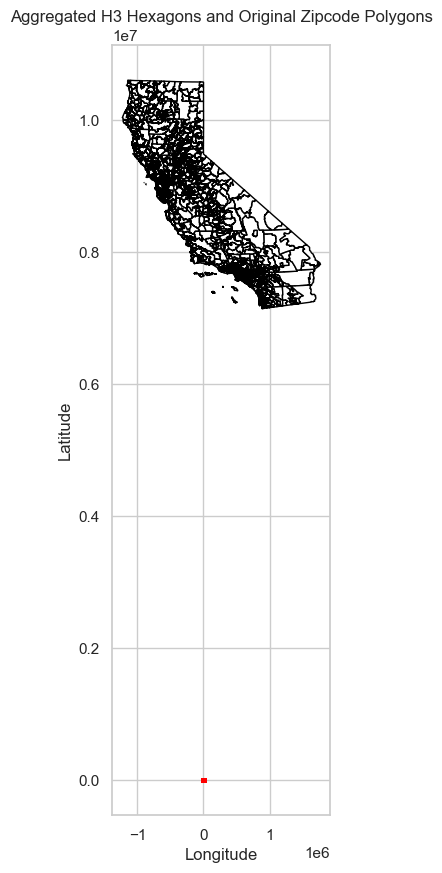

In [270]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
base = merged_gdf.plot(ax=ax, color='white', edgecolor='black')
aggregated_gdf.plot(ax=base, marker='o', color='red', markersize=5)
plt.title('Aggregated H3 Hexagons and Original Zipcode Polygons')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()#

# Data merged with VLM

                 Q__h3index  uplift_cm_  uplift_c00  uplift_c01  subsidence  \
0 608693239708385280.000000         NaN         NaN         NaN    0.070732   
1 608691600104620032.000000    0.000021    0.126816    0.039374    0.000008   
2 608719098246856704.000000         NaN         NaN         NaN    0.317841   
3 608690106831732736.000000    0.000002    0.093207    0.048757    0.000059   
4 608719102374051840.000000    0.000439    0.289279    0.109224    0.000243   

   subsiden00  subsiden01  VLMcm_tota  VLMcm_mean          GRID_ID  ...  \
0    0.098272    0.085049 4307.000000   -0.085049  8728346c9ffffff  ...   
1    0.074027    0.020725 4171.000000    0.023481  87281c909ffffff  ...   
2    0.446562    0.377935 3402.000000   -0.377935  8729acb72ffffff  ...   
3    0.037073    0.009461 3813.000000    0.043978  872806d5bffffff  ...   
4    1.012682    0.117616 2593.000000   -0.115429  8729acc68ffffff  ...   

          F2017         F2018         F2019       Average    Shape_Leng  \

AttributeError: 'NoneType' object has no attribute 'shape'

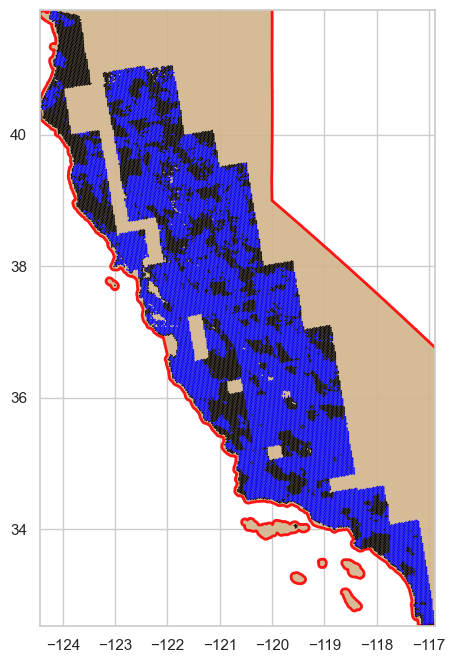

In [336]:
caborder = gpd.read_file(r'C:\Users\wetzl\Desktop\ArcGIS\data\borders\CAstate2023\CA_State.shp')
zhvivlm = gpd.read_file(r'C:\Users\wetzl\Desktop\FME\william\vlm\zhvivlm\zhvivlm.shp')
caborder = caborder.to_crs(zhvivlm.crs)

# Create a new column 'value_indicator' to distinguish between Value and No Value hexagons
zhvivlm['value_indicator'] = zhvivlm.apply(
    lambda row: 'Value' if pd.notna(row['Average']) and row['Average'] != 0 and pd.notna(row['subsiden01']) and row['subsiden01'] != 0 else 'No Value',
    axis=1
)
zhvivlm['subaccum'] = zhvivlm['subsiden01'] * 20
print(zhvivlm.head())



fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the California border with a transparent tan fill
caborder.plot(ax=ax, facecolor='#D2B48C', edgecolor='red', linewidth=2, alpha=0.9, label='California')

# Plot the hexagons with values
zhvivlm[zhvivlm['value_indicator'] == 'Value'].plot(
    ax=ax, color='blue', edgecolor='none', label='ZHVI Data'
)

# Plot the hexagons with no values
zhvivlm[zhvivlm['value_indicator'] == 'No Value'].plot(
    ax=ax, color='black', edgecolor='none', label='Missing ZHVI Data'
)

# Set the extent of the plot to match your main dataset
ax.set_xlim(zhvivlm.total_bounds[0], zhvivlm.total_bounds[2])
ax.set_ylim(zhvivlm.total_bounds[1], zhvivlm.total_bounds[3])

# Add the basemap
ctx.add_basemap(ax, crs=zhvivlm.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

# Add a title
plt.title('Regions with Values in Average and Subsiden01 (Blue) and NaNs or Zeros (Black)')

# Add a legend with proper labels
handles, labels = ax.get_legend_handles_labels()
labels_dict = {
    'California': 'California (Border and Shading)',
    'ZHVI Data': 'Regions with ZHVI Data (Blue)',
    'Missing ZHVI Data': 'Regions Missing ZHVI Data (Black)'
}
new_labels = [labels_dict[label] for label in labels]
ax.legend(handles, new_labels, loc='upper right')

# Remove axis
plt.axis('off')

# Show the plot
plt.show()

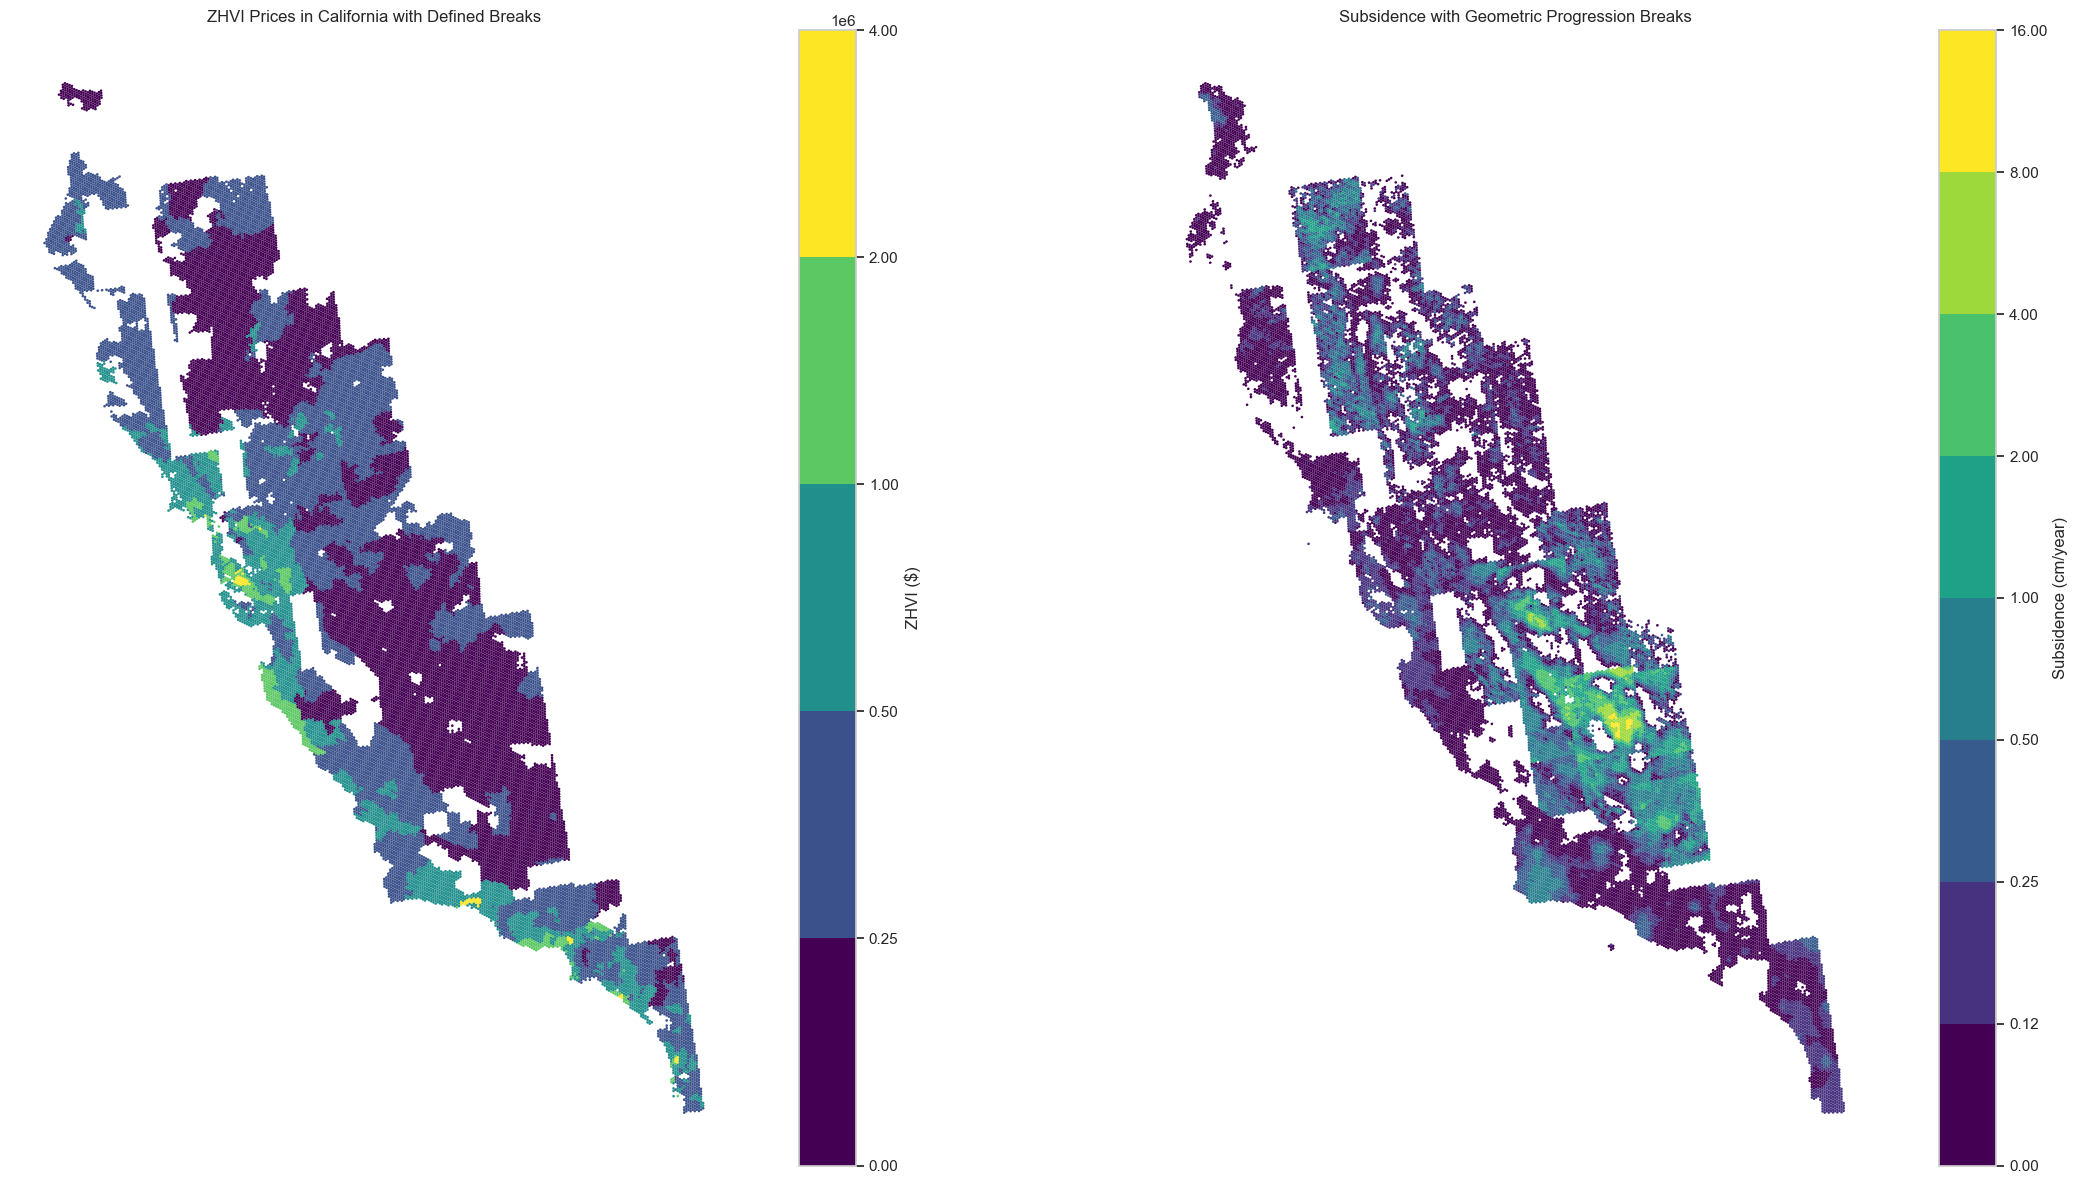

In [358]:
# Filter the DataFrame to include only nonzero and non-null (rational) values
filtered_zhvi = zhvivlm[(zhvivlm['Average'].notna()) & (zhvivlm['Average'] != 0)]
filtered_subsidence = zhvivlm[(zhvivlm['subsiden01'].notna()) & (zhvivlm['subsiden01'] != 0)]

# Create a figure and axes for ZHVI and Subsidence side by side
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

# Define break points for the color map for ZHVI
zhvi_boundaries = [0, 250000, 500000, 1000000, 2000000, 4000000]  # Example boundaries
cmap = plt.cm.viridis  # You can choose any color map you like

# Normalize the values for the color map using BoundaryNorm for ZHVI
zhvi_norm = mcolors.BoundaryNorm(zhvi_boundaries, cmap.N, clip=True)

# Plot the data with the defined breaks for ZHVI
filtered_zhvi.plot(column='Average', cmap=cmap, linewidth=0.8, ax=axs[0], edgecolor='none', norm=zhvi_norm)

# Add a color bar for ZHVI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=zhvi_norm)
sm._A = []  # Array to control the color bar, empty because we only want the color scale
cbar = fig.colorbar(sm, ax=axs[0], boundaries=zhvi_boundaries, ticks=zhvi_boundaries)
cbar.set_label('ZHVI ($)')

# Set the title for ZHVI plot
axs[0].set_title('ZHVI Prices in California with Geometric Breaks')
axs[0].axis('off')


# Define break points for the color map for Subsidence
vlm_boundaries = [0, .125, .25, 0.5, 1, 2, 4, 8, 16]
cmap = plt.cm.viridis  # You can choose any color map you like

# Normalize the values for the color map using BoundaryNorm for Subsidence
norm = mcolors.BoundaryNorm(vlm_boundaries, cmap.N, clip=True)

# Plot the data with the defined breaks for Subsidence
filtered_subsidence.plot(column='subsiden01', cmap=cmap, linewidth=0.8, ax=axs[1], edgecolor='none', norm=norm)

# Add a color bar for Subsidence
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Array to control the color bar, empty because we only want the color scale
cbar = fig.colorbar(sm, ax=axs[1], boundaries=vlm_boundaries, ticks=vlm_boundaries)
cbar.set_label('Subsidence (cm/year)')

# Set the title for Subsidence plot
axs[1].set_title('Subsidence with Geometric Breaks')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Basemap loading error: 'NoneType' object has no attribute 'shape'


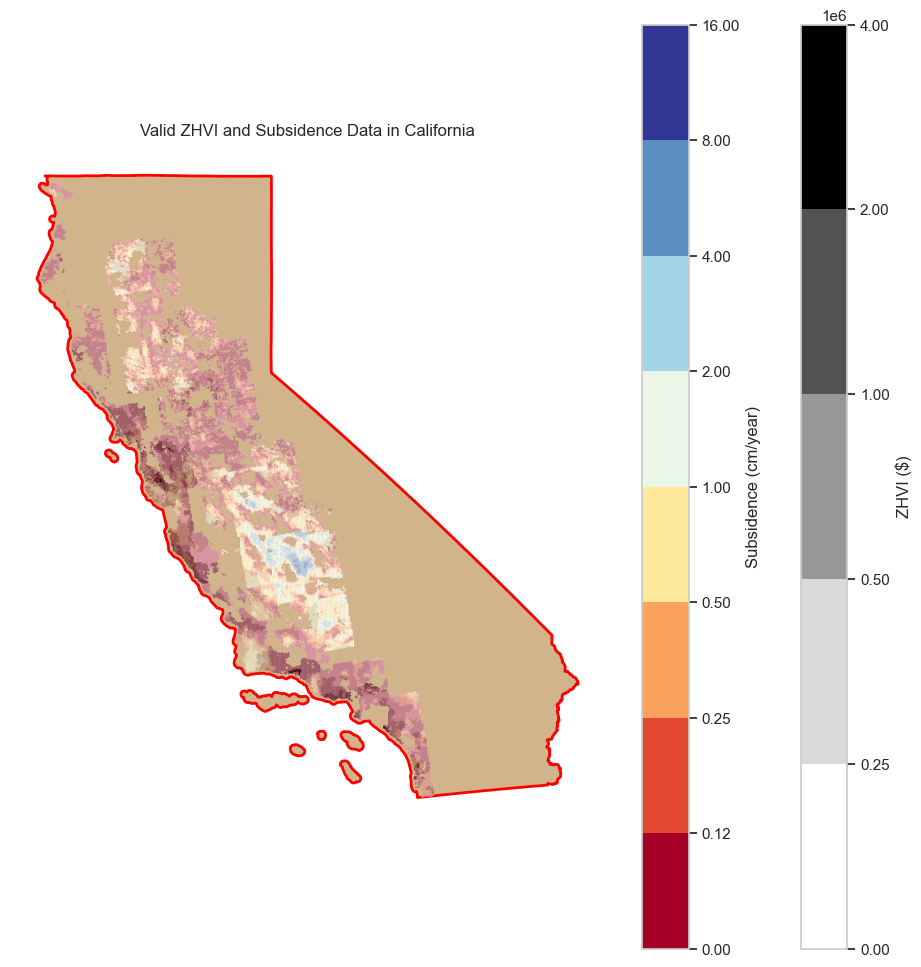

In [337]:
# Ensure both shapefiles have the same CRS
caborder = caborder.to_crs(zhvivlm.crs)

# Filter the DataFrame to include only regions with valid values for both Average and subsiden01
valid_data = zhvivlm[(zhvivlm['Average'].notna()) & (zhvivlm['Average'] != 0) & 
                     (zhvivlm['subsiden01'].notna()) & (zhvivlm['subsiden01'] != 0)]

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the California border first to ensure it is in the background
caborder.plot(ax=ax, facecolor='#D2B48C', edgecolor='red', linewidth=2, label='California')


# Define break points for the color map for ZHVI (Average)
zhvi_boundaries = [0, 250000, 500000, 1000000, 2000000, 4000000]  # Example boundaries
grayscale_cmap = plt.cm.Greys  # Grayscale color map for ZHVI

# Normalize the values for the color map using BoundaryNorm for ZHVI
zhvi_norm = mcolors.BoundaryNorm(zhvi_boundaries, grayscale_cmap.N, clip=True)

# Plot the data with the defined breaks for ZHVI in grayscale
valid_data.plot(column='Average', cmap=grayscale_cmap, linewidth=0.8, ax=ax, edgecolor='none', norm=zhvi_norm)

# Overlay the Subsidence data with transparency
subsidence_boundaries = [0, .125, .25, 0.5, 1, 2, 4, 8, 16]
cmap = plt.cm.RdYlBu # Color map for subsidence

# Normalize the values for the color map using BoundaryNorm for Subsidence
subsidence_norm = mcolors.BoundaryNorm(subsidence_boundaries, cmap.N, clip=True)

# Plot the subsidence data with transparency
valid_data.plot(column='subsiden01', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='none', norm=subsidence_norm, alpha=0.4)

# Add color bars
sm_zhvi = plt.cm.ScalarMappable(cmap=grayscale_cmap, norm=zhvi_norm)
sm_zhvi._A = []  # Array to control the color bar, empty because we only want the color scale
cbar_zhvi = fig.colorbar(sm_zhvi, ax=ax, boundaries=zhvi_boundaries, ticks=zhvi_boundaries)
cbar_zhvi.set_label('ZHVI ($)')

sm_subsidence = plt.cm.ScalarMappable(cmap=cmap, norm=subsidence_norm)
sm_subsidence._A = []  # Array to control the color bar, empty because we only want the color scale
cbar_subsidence = fig.colorbar(sm_subsidence, ax=ax, boundaries=subsidence_boundaries, ticks=subsidence_boundaries)
cbar_subsidence.set_label('Subsidence (cm/year)')

# Set the title for the plot
plt.title('Valid ZHVI and Subsidence Data in California')
plt.axis('off')

# Add the basemap with error handling
try:
    ctx.add_basemap(ax, crs=zhvivlm.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
except Exception as e:
    print(f"Basemap loading error: {e}")

plt.show()

In [351]:
# Select the relevant columns
data_subset = valid_data[['Average', 'subsiden01']]

# Drop rows with NaN values in the selected columns
data_subset = data_subset.dropna(subset=['Average', 'subsiden01'])
# Calculate the correlation
correlation = data_subset['Average'].corr(data_subset['subsiden01'])
print(f"Linear Correlation: {correlation}")

correlationspear = data_subset['Average'].corr(data_subset['subsiden01'], method='spearman')
print(f'Spearman Correlation Coefficient: {correlationspear:.2f}')

Linear Correlation: -0.22469813538929603
Spearman Correlation Coefficient: -0.41


## Distribution and Correlation

Correlation Coefficient: -0.17546244944071954
Spearman Correlation Coefficient: -0.29


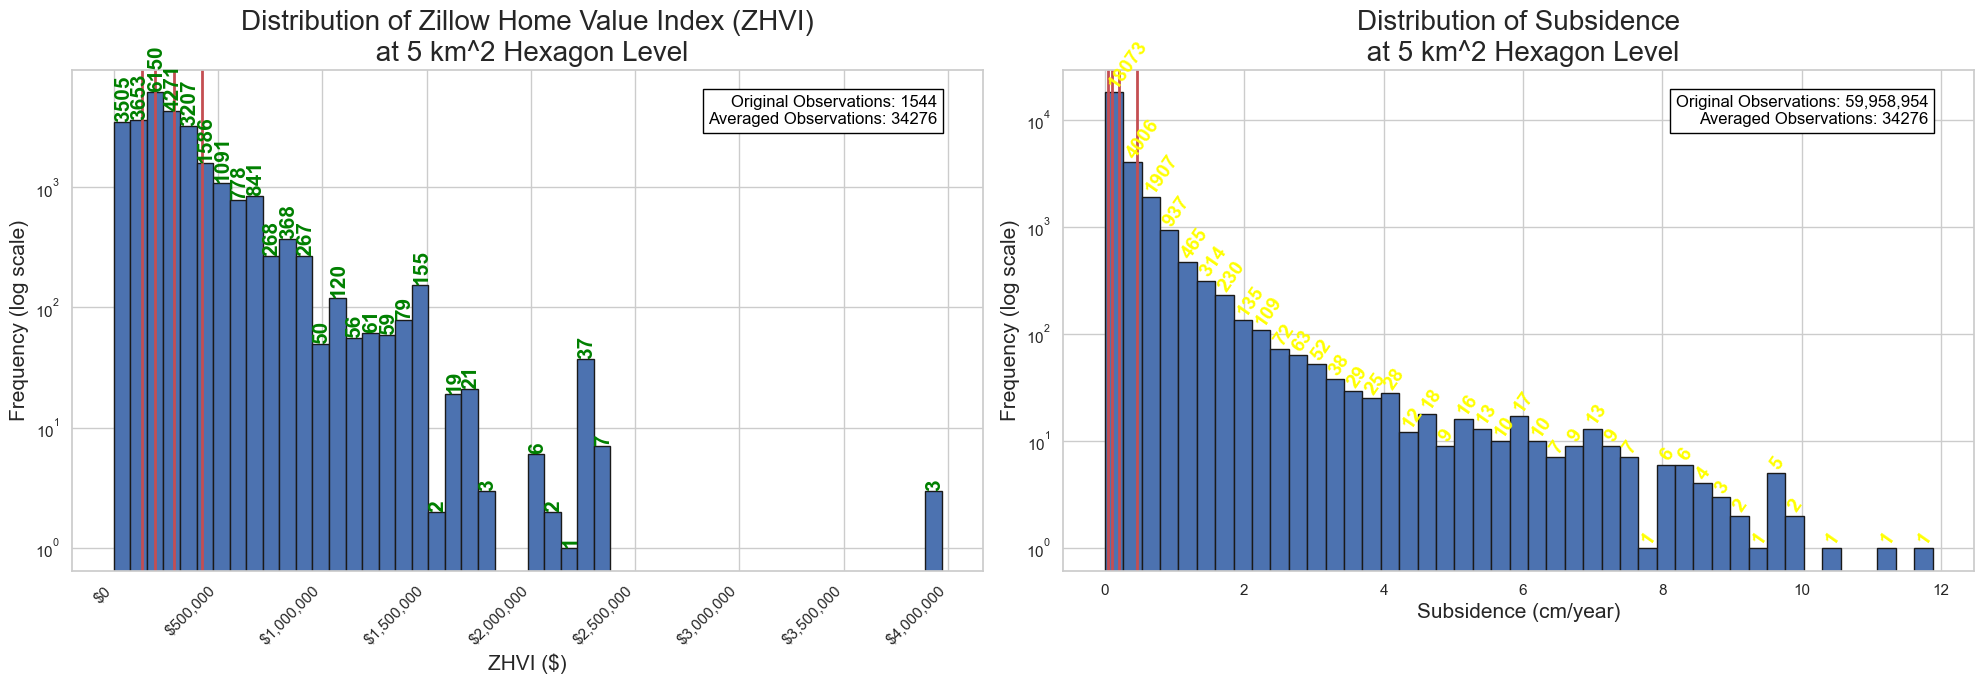

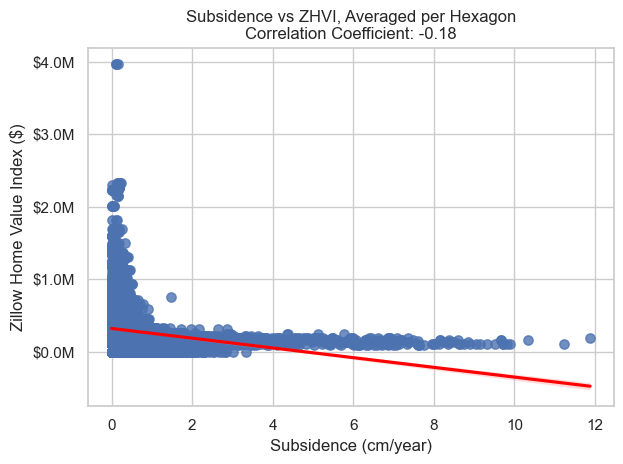

In [356]:
# Prepare the data
avgzhvi = zhvivlm['Average']
subsidence = zhvivlm['subsiden01']
zvlm = pd.DataFrame({'Average': avgzhvi, 'subsidence': subsidence})
dropna = zhvivlm.dropna(subset=['Average', 'subsiden01'])
avgobs = len(zvlm)
vlmobs = f'59,958,954'
# Calculate the correlation coefficient
correlation = dropna['Average'].corr(dropna['subsiden01'])
print(f'Correlation Coefficient: {correlation}')
correlationspear = dropna['Average'].corr(dropna['subsiden01'], method='spearman')
print(f'Spearman Correlation Coefficient: {correlationspear:.2f}')

plt.figure(figsize=(20, 7))

# ZHVI Distribution
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(dropna['Average'], bins=50, edgecolor='k')
plt.title('Distribution of Zillow Home Value Index (ZHVI)\n at 5 km^2 Hexagon Level', fontsize=20)
plt.xlabel('ZHVI ($)', fontsize=15)
plt.ylabel('Frequency (log scale)', fontsize=15)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.xticks(rotation=45, ha='right')

# Add value labels to bars
for i, v in enumerate(n):
    if v > 0:  # Only label bars with non-zero frequency
        plt.text(bins[i], v, str(int(v)), ha='left', va='bottom', rotation=90, color='green', fontweight='bold', fontsize=15)
        
# Calculate percentiles for 'Average'
percentiles_zhvi = np.percentile(dropna['Average'], [20, 40, 60, 80])
for percentile in percentiles_zhvi:
    plt.axvline(percentile, color='r', linewidth=2)

plt.text(0.95, 0.95, f'Original Observations: {num_CA_observations}\nAveraged Observations: {avgobs}',
         fontsize=12, color='black', ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black'))
    
    
# Subsidence Distribution
plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(dropna['subsiden01'], bins=45, edgecolor='k')
plt.title('Distribution of Subsidence\n at 5 km^2 Hexagon Level', fontsize=20)
plt.xlabel('Subsidence (cm/year)', fontsize=15)
plt.ylabel('Frequency (log scale)', fontsize=15)
plt.yscale('log')  # Set y-axis to logarithmic scale

# Add value labels to bars
for i, v in enumerate(n):
    if v > 0:  # Only label bars with non-zero frequency
        plt.text(bins[i], v, str(int(v)), ha='left', va='bottom', rotation=55, color='yellow', fontweight='bold', fontsize=14)
        
# Calculate percentiles for 'subsiden01'
percentiles_subsidence = np.percentile(dropna['subsiden01'], [20, 40, 60, 80])
for percentile in percentiles_subsidence:
    plt.axvline(percentile, color='r', linewidth=2)
    
plt.text(0.95, 0.95, f'Original Observations: {vlmobs}\nAveraged Observations: {avgobs}',
         fontsize=12, color='black', ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()


#SCATTER PLOT AND REGRESSION
# Assign the result of regplot to ax
ax = sns.regplot(data=dropna, x='subsiden01', y='Average', scatter_kws={'s':45}, line_kws={'color':'red'})

plt.title(f'Subsidence vs ZHVI, Averaged per Hexagon\nCorrelation Coefficient: {correlation:.2f}')
plt.xlabel('Subsidence (cm/year)')
plt.ylabel('Zillow Home Value Index ($)')

# Define the formatter function
def millions_formatter(x, pos):
    return f'${x/1e6:.1f}M'

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Optionally, adjust the number of y-axis ticks if needed
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

             Average   subsiden01
count   26666.000000 26666.000000
mean   298306.111552     0.351868
std    267006.083215     0.698618
min         0.000000     0.000020
25%    156752.201711     0.059293
50%    239205.053859     0.145660
75%    364708.470808     0.362715
max   3969487.132670    11.877329


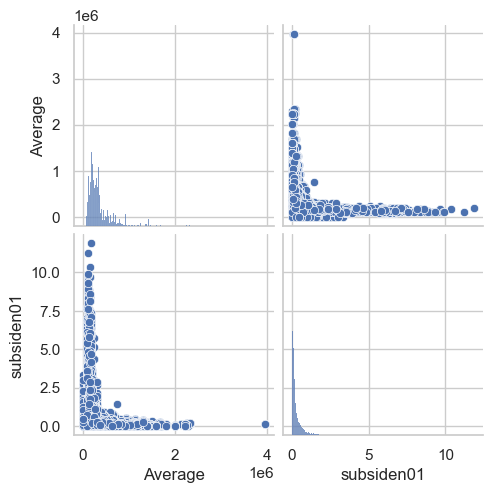

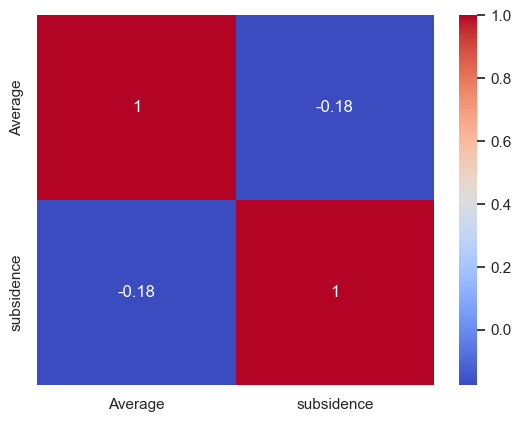

In [343]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(dropna[['Average', 'subsiden01']].describe())

sns.pairplot(dropna[['Average', 'subsiden01']])
plt.show()

correlation_matrix = zvlm.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [180]:
anova_result = stats.f_oneway(dropna['Average'], dropna['subsiden01'])
print(f'ANOVA result: {anova_result}')


X_with_const = add_constant(dropna[['subsiden01']])

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

ANOVA result: F_onewayResult(statistic=33284.25497633193, pvalue=0.0)
      feature       VIF
0       const  1.253687
1  subsiden01  1.000000


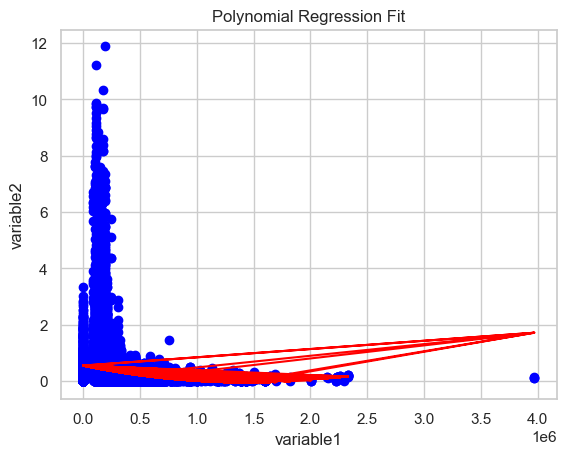

C:\Users\wetzl\PycharmProjects\earth-engine\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


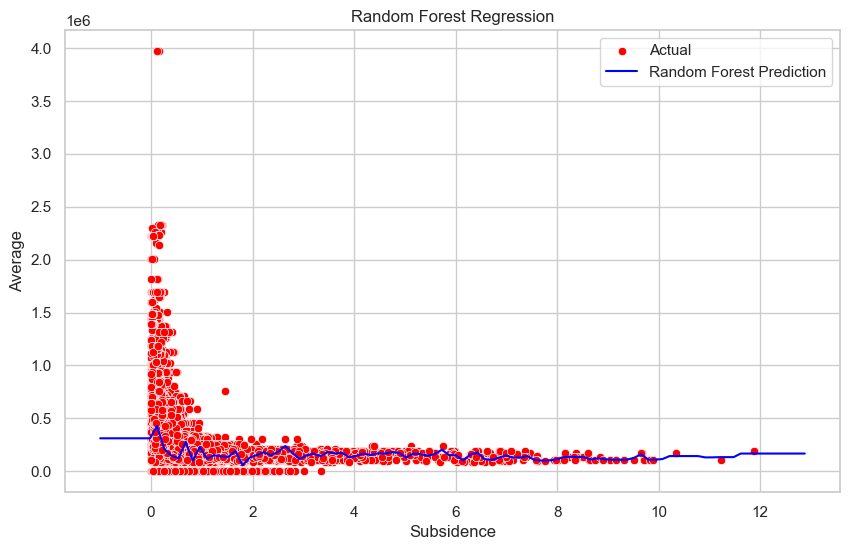

In [342]:
# Transform the features to polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(dropna[['Average']])

# Fit the model
poly_model = LinearRegression().fit(X_poly, dropna['subsiden01'])

# Plotting
plt.scatter(dropna['Average'], dropna['subsiden01'], color='blue')
plt.plot(dropna['Average'], poly_model.predict(X_poly), color='red')
plt.xlabel('variable1')
plt.ylabel('variable2')
plt.title('Polynomial Regression Fit')
plt.show()

X = dropna[['subsiden01']]
y = dropna['Average']

# Fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Create a mesh grid for plotting
x_min, x_max = X['subsiden01'].min() - 1, X['subsiden01'].max() + 1
xx = np.linspace(x_min, x_max, 100).reshape(-1, 1)

# Predict using the trained model
y_pred = model.predict(xx)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='subsiden01', y='Average', data=dropna, color='red', label='Actual')
plt.plot(xx, y_pred, color='blue', label='Random Forest Prediction')
plt.xlabel('Subsidence')
plt.ylabel('Average')
plt.title('Random Forest Regression')
plt.legend()
plt.show()